In [ ]:
import numpy as  np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

random_seed = 42
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # multi-GPU

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Data Load

In [ ]:
bitcoin_dataset_path1 = "/content/gdrive/MyDrive/ML/dataset/bitcoin_stock.csv"
bitcoin_dataset_path2 = "/content/gdrive/MyDrive/ML/dataset/bitcoin.csv"
bitcoin_dataset_path3 = "/content/gdrive/MyDrive/ML/dataset/bitcoin_stock_twitter_test.csv"
bitcoin_dataset_path4 = "/content/gdrive/MyDrive/ML/dataset/bitcoin_stock_test.csv"
bitcoin_dataset_path5 = "/content/gdrive/MyDrive/ML/dataset/bitcoin_stock_twitter.csv"
bitcoin_dataset_path6 = "/content/gdrive/MyDrive/ML/dataset/bitcoin_stock_twitter_average.csv"
bitcoin_dataset_path7 = "/content/gdrive/MyDrive/ML/dataset/bitcoin_only_twitter.csv"
data = pd.read_csv(bitcoin_dataset_path7)
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Twitter_senti
0,2019-05-18,7341.66,7447.27,7251.50,7271.21,2.135429e+10,1.290000e+11,0.252469
1,2019-05-19,7267.96,8261.94,7267.96,8197.69,2.590242e+10,1.450000e+11,0.257857
2,2019-05-20,8196.92,8200.97,7678.78,7978.31,2.384340e+10,1.410000e+11,0.191179
3,2019-05-21,7977.97,8062.17,7843.34,7963.33,2.512725e+10,1.410000e+11,0.216300
4,2019-05-22,7956.29,7997.61,7615.99,7680.07,2.471947e+10,1.360000e+11,0.230968


In [ ]:
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)
high_price = data['High'].values
low_price = data['Low'].values
close_price = data['Close'].values

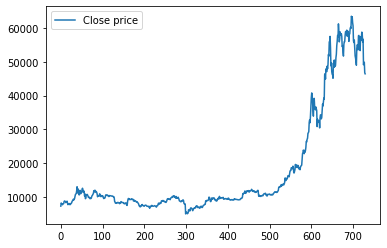

In [ ]:
close_price_df = pd.DataFrame(close_price)
plt.plot(close_price_df, label='Close price')
plt.legend()
plt.show()

In [ ]:
df = df.drop(columns='Volume')
df = df.drop(columns='Market Cap')
X = df
y = df.iloc[:, 3:4]

print(X)
print(y)

                Open      High       Low     Close  Twitter_senti
Date                                                             
2019-05-18   7341.66   7447.27   7251.50   7271.21       0.252469
2019-05-19   7267.96   8261.94   7267.96   8197.69       0.257857
2019-05-20   8196.92   8200.97   7678.78   7978.31       0.191179
2019-05-21   7977.97   8062.17   7843.34   7963.33       0.216300
2019-05-22   7956.29   7997.61   7615.99   7680.07       0.230968
...              ...       ...       ...       ...            ...
2021-05-12  56714.53  57939.36  49150.53  49150.53       0.317815
2021-05-13  49735.43  51330.84  46980.02  49716.19       0.317815
2021-05-14  49682.98  51438.12  48868.58  49880.53       0.317815
2021-05-15  49855.49  50639.67  46664.14  46760.19       0.317815
2021-05-16  46716.64  49720.04  43963.35  46456.06       0.317815

[730 rows x 5 columns]
               Close
Date                
2019-05-18   7271.21
2019-05-19   8197.69
2019-05-20   7978.31
2019-05-21   

##Data Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# Train Data
X_train = X_ss[:680, :]
X_test = X_ss[680:, :]

# Test Data 
y_train = y_mm[:680, :]
y_test = y_mm[680:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (680, 5) (680, 1)
Testing Shape (50, 5) (50, 1)


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([680, 1, 5]) torch.Size([680, 1])
Testing Shape torch.Size([50, 1, 5]) torch.Size([50, 1])


##LSTM Model

In [ ]:
class MYLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(MYLSTM, self).__init__()
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state 
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
    self.fc1 =  nn.Linear(hidden_size, 256) #fully connected 
    self.fc2 = nn.Linear(256, 1) #fully connected last layer
    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc2(out) #Final Output
   
    return out 

##Train

In [ ]:
num_epochs = 3000 
learning_rate = 0.00001 

input_size = 5 #number of features
hidden_size = 30 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

lstm = MYLSTM(input_size, hidden_size, num_layers)
loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)  # adam optimizer

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.07857
Epoch: 100, loss: 0.07171
Epoch: 200, loss: 0.06570
Epoch: 300, loss: 0.06042
Epoch: 400, loss: 0.05577
Epoch: 500, loss: 0.05168
Epoch: 600, loss: 0.04807
Epoch: 700, loss: 0.04483
Epoch: 800, loss: 0.04192
Epoch: 900, loss: 0.03922
Epoch: 1000, loss: 0.03667
Epoch: 1100, loss: 0.03421
Epoch: 1200, loss: 0.03181
Epoch: 1300, loss: 0.02948
Epoch: 1400, loss: 0.02720
Epoch: 1500, loss: 0.02496
Epoch: 1600, loss: 0.02275
Epoch: 1700, loss: 0.02055
Epoch: 1800, loss: 0.01838
Epoch: 1900, loss: 0.01623
Epoch: 2000, loss: 0.01416
Epoch: 2100, loss: 0.01219
Epoch: 2200, loss: 0.01033
Epoch: 2300, loss: 0.00862
Epoch: 2400, loss: 0.00707
Epoch: 2500, loss: 0.00569
Epoch: 2600, loss: 0.00450
Epoch: 2700, loss: 0.00350
Epoch: 2800, loss: 0.00266
Epoch: 2900, loss: 0.00199


##Result

In [ ]:
from sklearn.metrics import accuracy_score

df_X_ss = ss.transform(df)
df_y_mm = mm.transform(df.iloc[:, 3:4])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm(df_X_ss)#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

In [ ]:
data_predict_trans = data_predict[680:, :]
data_actual_trans = dataY_plot[680:, :]
actual_average = data_actual_trans.mean()
accuracy = (abs(data_predict_trans - data_actual_trans) / data_actual_trans) * 100
#accuracy = (data_predict_trans / data_actual_trans)*100  
#print(accuracy.mean())
print(100 - accuracy.mean())

89.243896484375


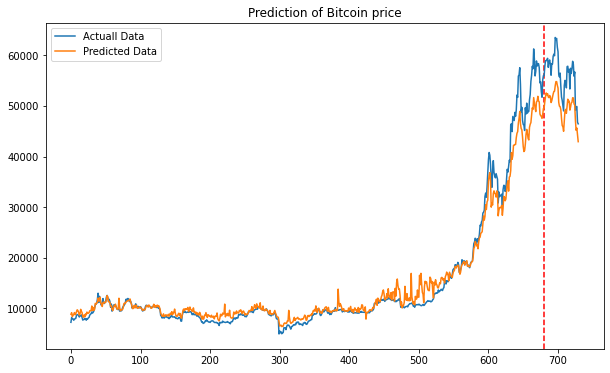

In [ ]:
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=680, c='r', linestyle='--') #size of the training set
plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Prediction of Bitcoin price')
plt.legend()
plt.show() 